In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import ssl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


seed = 1234
np.random.seed(seed)

# Required to prevent urlopen error where certificate has expired
ssl._create_default_https_context = ssl._create_unverified_context

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [84]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

batch_size = 256

gen = torch.Generator()
gen.manual_seed(seed)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, generator=gen)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, generator=gen)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, generator=gen)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


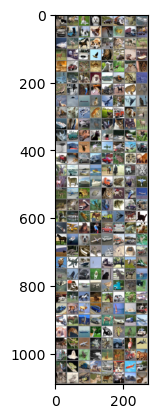

cat   horse dog   dog   car   truck dog   ship  car   truck dog   dog   cat   frog  truck car   ship  deer  horse dog   deer  cat   deer  bird  deer  truck car   bird  cat   bird  frog  ship  cat   car   frog  cat   dog   deer  deer  dog   cat   car   horse dog   ship  truck bird  plane bird  cat   bird  cat   truck horse frog  bird  deer  plane ship  bird  plane dog   plane cat   deer  dog   plane frog  bird  truck dog   deer  ship  bird  plane deer  bird  cat   dog   deer  cat   truck dog   horse ship  ship  truck cat   plane ship  deer  deer  plane bird  deer  truck truck dog   car   truck car   frog  cat   cat   deer  ship  ship  ship  horse dog   truck cat   deer  cat   ship  ship  truck frog  deer  plane bird  plane frog  frog  cat   dog   bird  plane frog  bird  truck bird  bird  frog  truck truck bird  ship  cat   horse truck plane horse cat   ship  plane horse bird  car   car   bird  horse horse ship  dog   plane car   truck car   deer  bird  bird  ship  cat   ship  plane dog 

In [85]:
# functions to show an image

# transpose image RGB channels so it can be viewed in color
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [86]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits
    
# single hidden layer convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input 3 channel images, output 6 channel images, kernel size 5x5
        self.pool = nn.MaxPool2d(2, 2) # 2x2 pooling
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Test network to understand what all the numbers mean
class NetTest(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # kernel size 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 pooling
        
        # start with 32x32 but for every conv2d subtract (kernel_size-1) for current image size
        # so size is 28x28 now
        # for every MaxPool2d divide by 2 (the stride)
        # so size is 14x14 now
        # 6 * 14 * 14 is the num of columns in the matrix after flatten happens in forward propogation
        self.fc1 = nn.Linear(6 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # torch.Size([4, 3, 32, 32])
        # torch.Size([4, 6, 28, 28])
        # torch.Size([4, 6, 14, 14])
        # torch.Size([4, 1176])
        
        #print(np.shape(x))
        x = F.relu(self.conv1(x))
        #print(np.shape(x))
        x = self.pool(x)
        #print(np.shape(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(np.shape(x))
        x = F.relu(self.fc1(x))
        #print(np.shape(x))
        x = F.relu(self.fc2(x))
        #print(np.shape(x))
        x = self.fc3(x)
        #print(np.shape(x))
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [87]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [88]:
torch.manual_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [89]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 2.303
[1,    20] loss: 2.297
[1,    30] loss: 2.296
[1,    40] loss: 2.293
[1,    50] loss: 2.285
[1,    60] loss: 2.270
[1,    70] loss: 2.250
[1,    80] loss: 2.230
[1,    90] loss: 2.194
[1,   100] loss: 2.172
[1,   110] loss: 2.129
[1,   120] loss: 2.101
[1,   130] loss: 2.059
[1,   140] loss: 2.038
[1,   150] loss: 2.019
[2,    10] loss: 1.987
[2,    20] loss: 1.976
[2,    30] loss: 1.949
[2,    40] loss: 1.963
[2,    50] loss: 1.935
[2,    60] loss: 1.922
[2,    70] loss: 1.922
[2,    80] loss: 1.918
[2,    90] loss: 1.897
[2,   100] loss: 1.919
[2,   110] loss: 1.884
[2,   120] loss: 1.891
[2,   130] loss: 1.874
[2,   140] loss: 1.860
[2,   150] loss: 1.863
[3,    10] loss: 1.877
[3,    20] loss: 1.850
[3,    30] loss: 1.845
[3,    40] loss: 1.847
[3,    50] loss: 1.832
[3,    60] loss: 1.816
[3,    70] loss: 1.826
[3,    80] loss: 1.797
[3,    90] loss: 1.814
[3,   100] loss: 1.820
[3,   110] loss: 1.806
[3,   120] loss: 1.813
[3,   130] loss: 1.783
[3,   140] 

[24,    30] loss: 1.397
[24,    40] loss: 1.339
[24,    50] loss: 1.391
[24,    60] loss: 1.372
[24,    70] loss: 1.390
[24,    80] loss: 1.369
[24,    90] loss: 1.365
[24,   100] loss: 1.370
[24,   110] loss: 1.356
[24,   120] loss: 1.346
[24,   130] loss: 1.370
[24,   140] loss: 1.374
[24,   150] loss: 1.352
[25,    10] loss: 1.345
[25,    20] loss: 1.362
[25,    30] loss: 1.341
[25,    40] loss: 1.358
[25,    50] loss: 1.342
[25,    60] loss: 1.356
[25,    70] loss: 1.356
[25,    80] loss: 1.360
[25,    90] loss: 1.362
[25,   100] loss: 1.351
[25,   110] loss: 1.342
[25,   120] loss: 1.356
[25,   130] loss: 1.361
[25,   140] loss: 1.390
[25,   150] loss: 1.352
[26,    10] loss: 1.365
[26,    20] loss: 1.378
[26,    30] loss: 1.333
[26,    40] loss: 1.367
[26,    50] loss: 1.360
[26,    60] loss: 1.316
[26,    70] loss: 1.329
[26,    80] loss: 1.354
[26,    90] loss: 1.335
[26,   100] loss: 1.324
[26,   110] loss: 1.348
[26,   120] loss: 1.359
[26,   130] loss: 1.334
[26,   140] loss

['cat', 'cat', 'deer', 'cat']


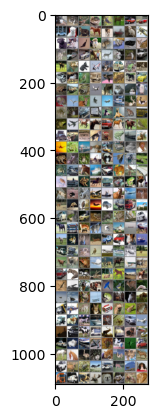

GroundTruth:  cat   cat   deer  cat  


In [90]:
dataiter = iter(valloader)
nextData = next(dataiter)
images, labels = nextData[0].to(device), nextData[1].to(device)

# print images

print([classes[labels[j]] for j in range(4)])

# convert to using CPU instead of GPU since it's not compatible for imshow
normalImages, normalLabels = images.to(torch.device('cpu')), labels.to(torch.device('cpu'))

imshow(torchvision.utils.make_grid(normalImages))
print('GroundTruth: ', ' '.join(f'{classes[normalLabels[j]]:5s}' for j in range(4)))


In [91]:
outputs = net(images)

# ignore first value
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   deer  frog  car  


In [92]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
correctTest = 0
totalTest = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        totalTest += labels.size(0)
        correctTest += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 testing images: {100 * correctTest // totalTest} %')
print(f'Accuracy of the network on the 10000 validation images: {100 * correct // total} %')

Accuracy of the network on the 10000 testing images: 53 %
Accuracy of the network on the 10000 validation images: 53 %


In [93]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 50.8 %
Accuracy for class: car   is 73.4 %
Accuracy for class: bird  is 45.9 %
Accuracy for class: cat   is 33.8 %
Accuracy for class: deer  is 34.9 %
Accuracy for class: dog   is 45.8 %
Accuracy for class: frog  is 67.5 %
Accuracy for class: horse is 56.0 %
Accuracy for class: ship  is 71.1 %
Accuracy for class: truck is 57.8 %


In [94]:
confMatrix = [[0 for _ in range(len(classes))] for _ in range(len(classes))]

with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            confMatrix[label][prediction] += 1

for row in confMatrix:
    print(row)

[508, 79, 98, 22, 19, 21, 21, 24, 155, 53]
[32, 739, 15, 7, 8, 9, 22, 8, 54, 113]
[58, 25, 448, 61, 92, 88, 112, 43, 22, 27]
[12, 23, 111, 337, 51, 201, 144, 51, 19, 49]
[42, 24, 216, 59, 374, 69, 167, 69, 20, 32]
[11, 16, 102, 177, 41, 445, 74, 76, 7, 22]
[4, 22, 88, 74, 67, 18, 688, 17, 10, 31]
[14, 17, 71, 62, 64, 101, 36, 548, 11, 55]
[87, 74, 29, 19, 7, 11, 6, 6, 705, 47]
[33, 217, 10, 30, 7, 8, 35, 24, 53, 570]


For 30 output channel images (60 output on the second conv2d):

Accuracy of the network on the 10000 test images: 61 %

Accuracy for class: plane is 46.2 %

Accuracy for class: car   is 83.4 %

Accuracy for class: bird  is 45.7 %

Accuracy for class: cat   is 33.0 %

Accuracy for class: deer  is 50.1 %

Accuracy for class: dog   is 50.5 %

Accuracy for class: frog  is 83.6 %

Accuracy for class: horse is 67.7 %

Accuracy for class: ship  is 90.2 %

Accuracy for class: truck is 61.7 %

For 1050 output channel images (2150 output on the second conv2d):

Accuracy of the network on the 10000 test images: 66 %
    
Accuracy for class: plane is 79.3 %
    
Accuracy for class: car   is 83.3 %
    
Accuracy for class: bird  is 35.5 %
    
Accuracy for class: cat   is 52.8 %
    
Accuracy for class: deer  is 46.5 %
    
Accuracy for class: dog   is 45.6 %
    
Accuracy for class: frog  is 88.1 %
    
Accuracy for class: horse is 75.4 %
    
Accuracy for class: ship  is 81.9 %
    
Accuracy for class: truck is 76.8 %

[1,  2000] loss: 1.884
    
[1,  4000] loss: 1.577
    
[1,  6000] loss: 1.419
    
[1,  8000] loss: 1.320
    
[1, 10000] loss: 1.255
    
[1, 12000] loss: 1.200
    
[2,  2000] loss: 1.078
    
[2,  4000] loss: 1.035
    
[2,  6000] loss: 1.041
    
[2,  8000] loss: 0.995
    
[2, 10000] loss: 0.992
    
[2, 12000] loss: 0.940
    

For 6 output channel images (6 output on second conv2d):

Accuracy of the network on the 10000 test images: 54 %

Accuracy for class: plane is 61.9 %

Accuracy for class: car   is 77.6 %

Accuracy for class: bird  is 31.5 %

Accuracy for class: cat   is 29.3 %

Accuracy for class: deer  is 52.7 %

Accuracy for class: dog   is 47.9 %

Accuracy for class: frog  is 62.6 %

Accuracy for class: horse is 64.2 %

Accuracy for class: ship  is 66.4 %

Accuracy for class: truck is 48.3 %

[1,  2000] loss: 2.042

[1,  4000] loss: 1.713

[1,  6000] loss: 1.625

[1,  8000] loss: 1.558

[1, 10000] loss: 1.496

[1, 12000] loss: 1.472

[2,  2000] loss: 1.396

[2,  4000] loss: 1.396

[2,  6000] loss: 1.355

[2,  8000] loss: 1.348

[2, 10000] loss: 1.341

[2, 12000] loss: 1.316


For 600 output channel images (1200 output on second conv2d):

Accuracy of the network on the 10000 test images: 67 %

Accuracy for class: plane is 71.7 %

Accuracy for class: car   is 75.1 %

Accuracy for class: bird  is 64.1 %

Accuracy for class: cat   is 42.1 %

Accuracy for class: deer  is 67.6 %

Accuracy for class: dog   is 41.8 %

Accuracy for class: frog  is 71.6 %

Accuracy for class: horse is 79.4 %

Accuracy for class: ship  is 84.3 %

Accuracy for class: truck is 80.8 %

[1,  2000] loss: 1.889

[1,  4000] loss: 1.538

[1,  6000] loss: 1.402

[1,  8000] loss: 1.343

[1, 10000] loss: 1.248

[1, 12000] loss: 1.178

[2,  2000] loss: 1.043

[2,  4000] loss: 1.049

[2,  6000] loss: 1.000

[2,  8000] loss: 0.962

[2, 10000] loss: 0.981

[2, 12000] loss: 0.920


For 90 output channel images (180 output on second conv2d):

Accuracy of the network on the 10000 test images: 70 %

Accuracy for class: plane is 61.7 %

Accuracy for class: car   is 79.2 %

Accuracy for class: bird  is 65.8 %

Accuracy for class: cat   is 52.5 %

Accuracy for class: deer  is 63.0 %

Accuracy for class: dog   is 54.8 %

Accuracy for class: frog  is 84.0 %

Accuracy for class: horse is 76.3 %

Accuracy for class: ship  is 85.4 %

Accuracy for class: truck is 85.7 %

[1,  2000] loss: 2.039

[1,  4000] loss: 1.645

[1,  6000] loss: 1.483

[1,  8000] loss: 1.405

[1, 10000] loss: 1.292

[1, 12000] loss: 1.226

[2,  2000] loss: 1.106

[2,  4000] loss: 1.089

[2,  6000] loss: 1.039

[2,  8000] loss: 1.004

[2, 10000] loss: 0.973

[2, 12000] loss: 0.964

[3,  2000] loss: 0.807

[3,  4000] loss: 0.817

[3,  6000] loss: 0.820

[3,  8000] loss: 0.806

[3, 10000] loss: 0.810

[3, 12000] loss: 0.803
